# Modeling - First Pass

### Installs, Packages, Seeds

In [1]:
%pip install efficientnet_pytorch

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p38/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install torch
# %pip install torchvision

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p38/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
%matplotlib inline

# python libraties
import os
import cv2
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import seaborn as sns
from itertools import combinations, product

# import imblearn
import logging
from tqdm import tqdm
from glob import glob
from PIL import Image
import ipywidgets

# pytorch libraries
import torch
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms
from efficientnet_pytorch import EfficientNet

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# google drive
# from google.colab import drive # Connect colab to google drive

# custom modeling libraries
from build_model2 import initialize_model, load_split_data, build_loader, evaluate, train_model, model_scores, eval_model, add_results

# other
import importlib

In [4]:
import build_model2
importlib.reload(build_model2)

from build_model2 import initialize_model, load_split_data, build_loader, evaluate, train_model, model_scores, eval_model, add_results

# import matplotlib as mpl
# print(mpl.get_cachedir())

## Grid Components

In [5]:
epoch_search = [10, 20, 50]
optim_search = ['SGD', 'Adam', 'AdamW']
model_search = ['resnet', 'vgg']
lr_search = [.000559, .001, .0025, .003, .0035]

prods = list(product(epoch_search, optim_search, model_search, lr_search))

es = pd.Series(list(zip(*prods))[0], name = 'epochs', dtype = 'int')
optims = pd.Series(list(zip(*prods))[1], name = 'optimizer')
mods = pd.Series(list(zip(*prods))[2], name = 'pretrained_model')
learns = pd.Series(list(zip(*prods))[3], name = 'learning_rate')

g_search = pd.concat([es, optims, mods, learns], axis = 1)

In [6]:
g_search.index+=35 # index to add to prior run
g_search

,epochs,optimizer,pretrained_model,learning_rate
35,10,SGD,resnet,0.000559
36,10,SGD,resnet,0.001000
37,10,SGD,resnet,0.002500
38,10,SGD,resnet,0.003000
39,10,SGD,resnet,0.003500
...,...,...,...,...
120,50,AdamW,vgg,0.000559
121,50,AdamW,vgg,0.001000
122,50,AdamW,vgg,0.002500
123,50,AdamW,vgg,0.003000


In [7]:
g_search = g_search.sample(25)

## Parameters

In [8]:
model_dict = {'pretrained_model': None, 
              'epochs': None, # NEEDS UPDATE
              'home_directory': '/home/ec2-user/SageMaker/teledermatologyAI_capstone',
              'mod_directory': '/home/ec2-user/SageMaker/teledermatologyAI_capstone/model/gridsearch3',
              'csv_name': 'full_data_rename',
              'split': 'split_3',
              'cl': 'label_0',
              'dev_state': False,
              'dev_sample': 15000,
              'seed': 99,
              'lr': .0035,                  # from prior gridsearch
              'batch_size':64,
              'num_workers':24,
              'transform':3,
              'results_file':'gridsearch_results',
              'model':None, # NEEDS UPDATE
              'device': torch.device('cuda:0'), # NEEDS UPDATE
              'optimizer': None, # NEEDS UPDATE
              'criterion': None, # NEEDS UPDATE
              'tuned_model_name': None, # NEEDS UPDATE
              'show_val_cm': False,
             }

np.random.seed(model_dict['seed'])
torch.cuda.manual_seed(model_dict['seed'])

# Check GPU
print('GPU Type:', torch.cuda.get_device_name())
print('GPU Count:', torch.cuda.device_count())

HOME = model_dict['home_directory']

GPU Type: Tesla T4
GPU Count: 1


In [9]:
cd $HOME

/home/ec2-user/SageMaker/teledermatologyAI_capstone


## Data

In [10]:
data, train, test, val = load_split_data(directory = model_dict['home_directory'],
                                         csv_name = model_dict['csv_name'], 
                                         data_split = model_dict['split'], 
                                         label = model_dict['cl'],
                                         mode = 'all',
                                         dev_state = model_dict['dev_state'], 
                                         dev_sample = model_dict['dev_sample'], 
                                         seed = model_dict['seed']
                                         )

In [11]:
# Label dictionary for evaluation
labels_idx = np.sort(data.label_idx.unique())
label_map = data[['label', 'label_idx']].drop_duplicates().sort_values('label_idx')
label_dict = dict(zip(label_map.label_idx, label_map['label']))
model_dict['label_dict'] = label_dict

## In for loop

In [12]:
# g_search = g_search[g_search['pretrained_model'] != 'efficientnet'][2:]

In [13]:
g_search.sort_index(inplace = True)
# g_search

In [14]:
model_dict['lr']

0.0035

In [ ]:
# Gridsearch

for i in g_search.iterrows():
    
    # extract gridsearch features
    model_dict['epochs'] = i[1]['epochs']
    model_dict['pretrained_model'] = i[1]['pretrained_model']
    model_dict['optimizer_name'] = i[1]['optimizer']
    model_dict['lr'] = i[1]['learning_rate']
    me = i[1]['epochs']
    mn = i[1]['pretrained_model']
    mo = i[1]['optimizer']
    mlr = i[1]['learning_rate']
    model_dict['alias'] = i[0]
    model_dict['tuned_model_name'] = f'{mn}_{me}e_{mo}_GS{i[0]}'
    direc = model_dict['mod_directory']
    nam = model_dict['tuned_model_name']
    print(f'Learning Rate: {mlr}')
    # set batch size
    if model_dict['pretrained_model'] == 'efficientnet':
        model_dict['batch_size'] = 3
    else: 
        model_dict['batch_size'] = 64
    
    # Load each model
    model_ft, input_size = initialize_model(model_name = model_dict['pretrained_model'], 
                                            num_classes = len(data.label.unique()),
                                            feature_extract = False, 
                                            use_pretrained=True)
    
    # Move model to GPU
    model = model_ft.to(model_dict['device'])
    
    model_dict.update({
                       'model':model,
                       'criterion': nn.CrossEntropyLoss().to(model_dict['device']),
    })
    
    # Define optimizer options:
    if model_dict['optimizer_name'] == 'SGD':
        model_dict.update({'optimizer': optim.SGD(model.parameters(), lr=model_dict['lr'])})
    elif model_dict['optimizer_name'] == 'Adam':
        model_dict.update({'optimizer': optim.Adam(model.parameters(), lr=model_dict['lr'])})
    elif model_dict['optimizer_name'] == 'AdamW':
        model_dict.update({'optimizer': optim.AdamW(model.parameters(), lr=model_dict['lr'])})
    
    # Update dictionary
    model_dict['resize'] = int(input_size/.85)

    
    # Set Transforms
    transform_header = [
                        transforms.Resize(model_dict['resize']), #255
                        transforms.CenterCrop(input_size)
                        ]

    transform_body = [
                      transforms.RandomHorizontalFlip(), # a
                      transforms.RandomVerticalFlip(), # b
                      transforms.RandomRotation(20), # c
                      transforms.RandomCrop(size=(input_size,input_size)), # d
#                       transforms.RandomInvert(), transforms.RandomPosterize(bits=2), # e
#                       transforms.RandomAdjustSharpness(sharpness_factor=2), # f
#                       transforms.RandomSolarize(threshold=192.0), # g
#                       transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1) # h
                      ]

    transform_footer = [transforms.ToTensor(), 
                      transforms.Normalize(mean=[.541, .414, .382], std=[.256,.215,.209])]
    
    val_transform = transforms.Compose([
                                      transforms.Resize(model_dict['resize']),
                                      transforms.CenterCrop(input_size),
                                      transforms.ToTensor(), 
                                      transforms.Normalize(mean=[.541, .414, .382], std=[.256,.215,.209])
                                    ])
    
    test_loader = build_loader(mode = 'test', df = test, transform = val_transform, batch_size = model_dict['batch_size'], num_workers = model_dict['num_workers'])
    val_loader = build_loader(mode = 'val', df = val, transform = val_transform, batch_size = model_dict['batch_size'], num_workers = model_dict['num_workers'])   
    
    transform_list = transform_header + transform_body + transform_footer
    train_transform = transforms.Compose(transform_list)
    train_loader = build_loader(mode = 'train', df = train, transform = train_transform, batch_size = model_dict['batch_size'], num_workers = model_dict['num_workers'])


    loaders = {'train_loader':train_loader,
                            'val_loader': val_loader,
                            'test_loader': test_loader}
    model_dict['loader'] = loaders

    pred_df, val_scores, tot_time = train_model(model_dict = model_dict)

    acc, f1, f2, f5, prec, rec, d_0, d_1, d_2, d_3, d_4 = val_scores
    

    pred_df.to_pickle(f'{direc}/{nam}_preds.pkl')
    
    col_dict = {
#              'model': pd.Series(dtype = 'int'),
#              'file': pd.Series(dtype = 'str'),
             'tuned_model': model_dict['tuned_model_name'],
             'transform': model_dict['transform'],
             'lr': model_dict['lr'],
             'pretrained_model': model_dict['pretrained_model'],
             'optimizer': model_dict['optimizer_name'],
             'epochs': model_dict['epochs'],
#              'num_classes': model_dict['num_classes'],
             'batch_size': model_dict['batch_size'],
             'workers': model_dict['num_workers'],
             'train_time': tot_time,
             'data_split': model_dict['split'],
             'label_set': model_dict['cl'],
             'accur': acc,
             'F1': f1,
             'F0.5': f5,
             'F2': f2,
             'benign_accur': d_0,
             'noncancerous_accur': d_1,
             'malignant_accur': d_2,
             'infection_accur': d_3,
             'unclassified_accur': d_4
    }
    
#     print(tdf.iloc[:i[0]+1][['transform', 'lr', 'accur']])
    add_results(model_dict['results_file'], direc, pd.DataFrame(col_dict, index = [i[0]]))
    print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')

Learning Rate: 0.000559
Starting Training resnet_10e_SGD_GS35
[epoch 1], [iter 100 of 211],[train loss 1.54109], [train acc 0.32906]
[epoch 1], [iter 200 of 211],[train loss 1.47066], [train acc 0.39672]
------------------------------------------------------------
[epoch 1], [val loss 1.35096], [val acc 0.48438]
------------------------------------------------------------

EPOCH 1 :
*****************************************************
Complete in 2m 22s
best record: [epoch 1], [val loss 1.35096], [val acc 0.48438]
*****************************************************
[epoch 2], [iter 100 of 211],[train loss 1.28936], [train acc 0.51438]
[epoch 2], [iter 200 of 211],[train loss 1.25894], [train acc 0.51500]
------------------------------------------------------------
[epoch 2], [val loss 1.21340], [val acc 0.52253]
------------------------------------------------------------

EPOCH 2 :
*****************************************************
Complete in 2m 28s
best record: [epoch 2], [val

In [ ]:
2+2

In [21]:
# model_dict['lr'] = .0035
# model_dict['pretrained_model']
# model_dict['epochs']

10

------------------------------------------------------------
[epoch test], [test loss 0.79331], [test acc 0.67996]
------------------------------------------------------------


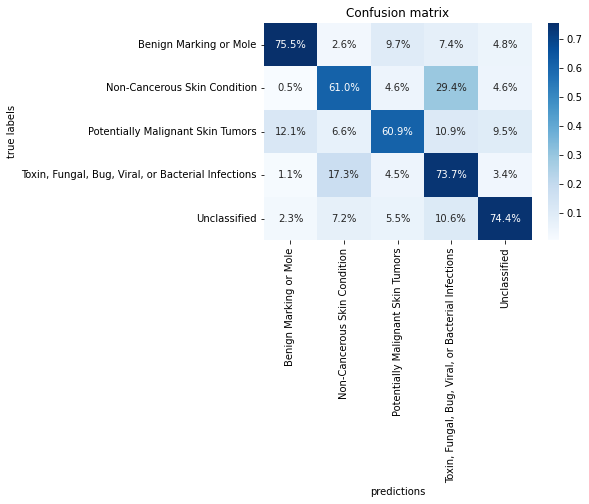

In [28]:
# # resnet_10e_SGD_GS9
pred_df = evaluate(model_name = 'gridsearch2/resnet_10e_SGD_GS9', 
                   model_source = 'pt', 
                   model_dict = model_dict, 
                   label_dict = label_dict, 
                   show_cm = True)

------------------------------------------------------------
[epoch test], [test loss 0.83571], [test acc 0.67349]
------------------------------------------------------------


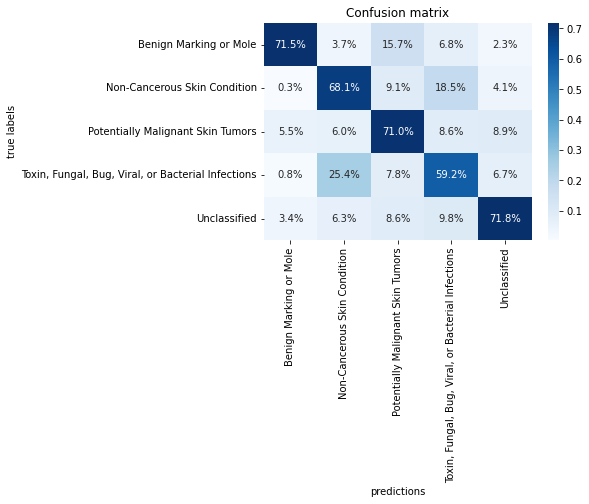

In [29]:
# # vgg_10e_SGD_GS10
pred_df = evaluate(model_name = 'gridsearch2/vgg_10e_SGD_GS10', 
                   model_source = 'pt', 
                   model_dict = model_dict, 
                   label_dict = label_dict, 
                   show_cm = True)

------------------------------------------------------------
[epoch test], [test loss 0.77828], [test acc 0.70151]
------------------------------------------------------------


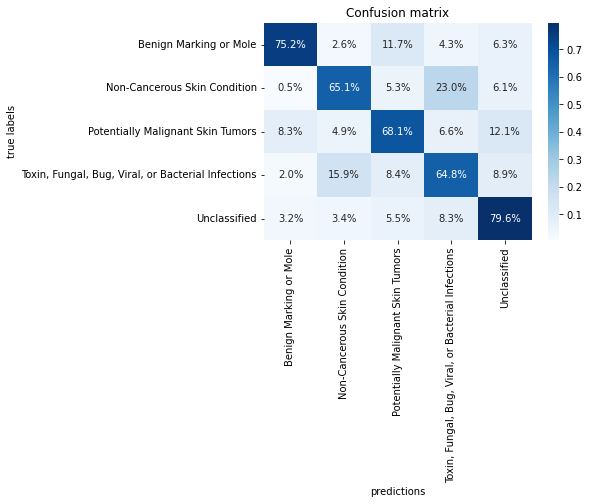

In [30]:
# # resnet_15e_SGD_GS18
pred_df = evaluate(model_name = 'gridsearch2/resnet_15e_SGD_GS18', 
                   model_source = 'pt', 
                   model_dict = model_dict, 
                   label_dict = label_dict, 
                   show_cm = True)

------------------------------------------------------------
[epoch test], [test loss 0.80067], [test acc 0.68858]
------------------------------------------------------------


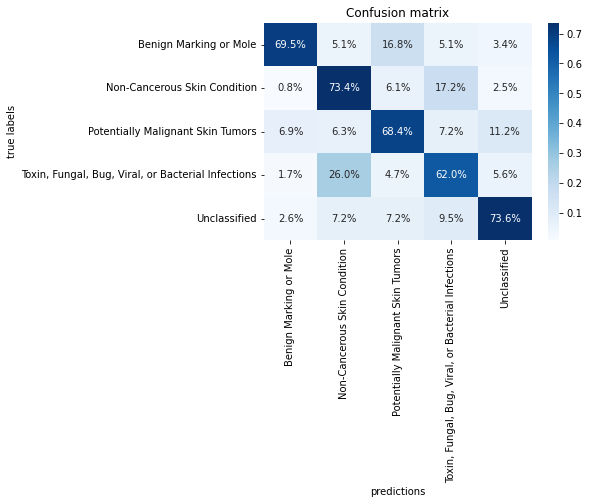

In [31]:
# # vgg_15e_SGD_GS19
pred_df = evaluate(model_name = 'gridsearch2/vgg_15e_SGD_GS19', 
                   model_source = 'pt', 
                   model_dict = model_dict, 
                   label_dict = label_dict, 
                   show_cm = True)

------------------------------------------------------------
[epoch test], [test loss 0.74069], [test acc 0.72899]
------------------------------------------------------------


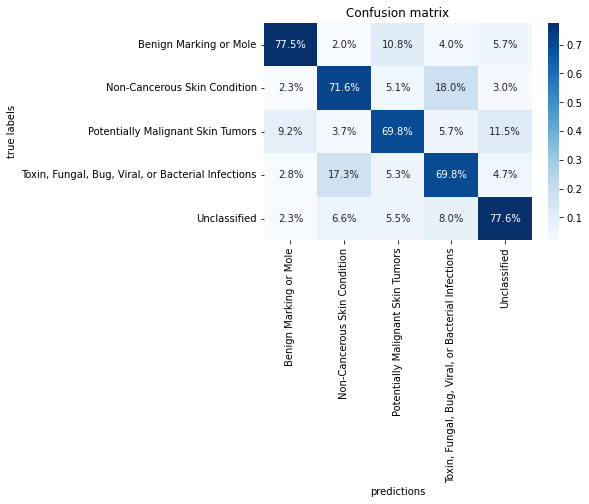

In [32]:
# # resnet_20e_SGD_GS27
pred_df = evaluate(model_name = 'gridsearch2/resnet_20e_SGD_GS27', 
                   model_source = 'pt', 
                   model_dict = model_dict, 
                   label_dict = label_dict, 
                   show_cm = True)

------------------------------------------------------------
[epoch test], [test loss 0.75048], [test acc 0.70690]
------------------------------------------------------------


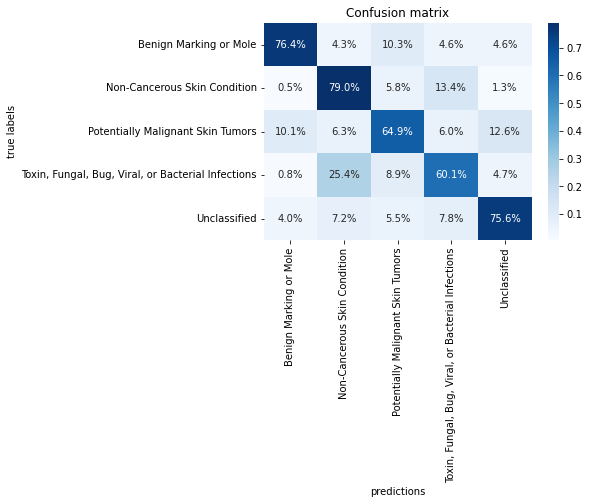

In [42]:

pred_df = evaluate(model_name = 'gridsearch2/vgg_20e_SGD_GS28', 
                   model_source = 'pt', 
                   model_dict = model_dict, 
                   label_dict = label_dict, 
                   show_cm = True)

------------------------------------------------------------
[epoch test], [test loss 1.08804], [test acc 0.74623]
------------------------------------------------------------


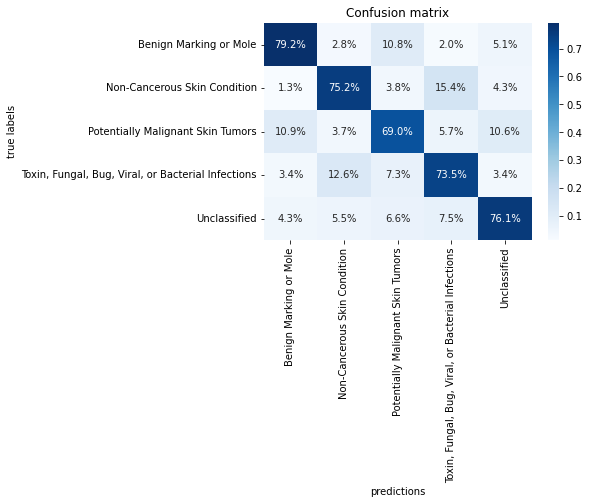

In [40]:
# # resnet_50e_SGD_GS98
pred_df = evaluate(model_name = 'gridsearch3/resnet_50e_SGD_GS98', 
                   model_source = 'pt', 
                   model_dict = model_dict, 
                   label_dict = label_dict, 
                   show_cm = True)

In [44]:
new = pd.read_csv('full_data_final_not_diverse.csv', index_col = 0)

/home/ec2-user/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (7,11,12,13,14,15,16,17,18,19,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [46]:
new.iloc[0].path

'./Data/dermnet/train/Nail Fungus and other Nail Disease/fissure-2.jpg'

In [59]:
new[new.image_id == 'ISIC_0000000'].path[0]

'./Data/ISIC_2019/ISIC_2019_Training_Input/ISIC_0000000.jpg'

In [60]:
ipath = './Data/ISIC_2019/ISIC_2019_Training_Input/ISIC_0000000.jpg'
image = mp_image.imread(ipath)
imshow(image)
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (15, 15))
axes.imshow(image)

FileNotFoundError: [Errno 2] No such file or directory: './Data/ISIC_2019/ISIC_2019_Training_Input/ISIC_0000000.jpg'